# Converting Models to Computation Graphs

using Pkg
Pkg.status()
Pkg.activate(".")

Pkg.instantiate()

Pkg.develop(path="../../")
Pkg.instantiate()

In [1]:
using AlgebraicPetri
using AlgebraicPetri.Epidemiology
using AlgebraicPetri.BilayerNetworks

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
import Catlab.CategoricalAlgebra: migrate!
using Catlab.WiringDiagrams
using Catlab.Programs.RelationalPrograms
display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>".75"));

using PrettyTables
function printsoln(bn::AbstractLabelledBilayerNetwork, soln::Vector)
    pretty_table(soln)
end

printsoln (generic function with 1 method)

#### SIR Model:

define model

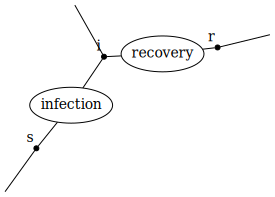

In [2]:
sir = @relation (s,i,r) begin
    infection(s,i)
    recovery(i,r)
end
display_uwd(sir)

Extract the Petri network form of the model.

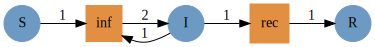

In [3]:
psir = apex(oapply_epi(sir))
psir
to_graphviz(psir)

Convert the Petri network into a bilayer network and draw it.
This model uses a computation graph to express the computation of the vector field of the Petri net.

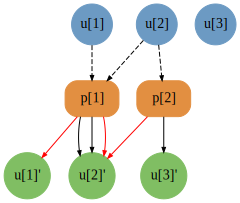

In [4]:
bnsir = BilayerNetwork()
migrate!(bnsir, psir)
bnsir
to_graphviz(bnsir)

We can hand code a Bilayer netowork using the `@acset` macro provided by Catlab. As you can see from the code,
there is a lot of typing to specify the incidence of all these wires. The Petri Net is more compact.
This notion of Bilayer network comes from the definition of mass action kinetics for reaction networks.

hand coded Bilayer network

In [5]:
bnsir_test = @acset BilayerNetwork begin
    Qin = 3
    Qout = 3
    Win = 3
    Wa = 3
    Wn = 3
    Box = 2
    arg = [1,2,2]
    call = [1,1,2]
    efflux = [1,1,2]
    effusion = [1,2,2]
    influx = [1,1,2]
    infusion = [2,2,3]
end

@assert bnsir == bnsir_test

function roundtrip(pn::AbstractPetriNet, bn::AbstractBilayerNetwork)
    roundtrippetri = PetriNet()
    migrate!(roundtrippetri, bn)
    pn_structure = PetriNet()
    copy_parts!(pn_structure, pn)
    return roundtrippetri, pn_structure
end

roundtrip (generic function with 1 method)

We can specify the SEIR model with the relation macro and functorial semantics as usual.

In [6]:
seir = @relation (s,e,i,r) begin
    exposure(s,i,e)
    illness(e,i)
    recovery(i,r)
end

pseir = apex(oapply_epi(seir))

LabelledPetriNet {T:3, S:4, I:4, O:4, Name:0}
┌───┬───────┐
│ T │ tname │
├───┼───────┤
│ 1 │   exp │
│ 2 │   ill │
│ 3 │   rec │
└───┴───────┘
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     S │
│ 2 │     I │
│ 3 │     E │
│ 4 │     R │
└───┴───────┘
┌───┬────┬────┐
│ I │ it │ is │
├───┼────┼────┤
│ 1 │  1 │  1 │
│ 2 │  1 │  2 │
│ 3 │  2 │  3 │
│ 4 │  3 │  2 │
└───┴────┴────┘
┌───┬────┬────┐
│ O │ ot │ os │
├───┼────┼────┤
│ 1 │  1 │  3 │
│ 2 │  1 │  2 │
│ 3 │  2 │  2 │
│ 4 │  3 │  4 │
└───┴────┴────┘

By converting this to a Bilayer network, we are able to visualize differences in the computational pattern
of data flow between different reaction network models.

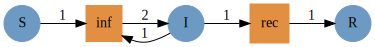

In [7]:
bnseir = BilayerNetwork()
migrate!(bnseir, pseir)

bnrt,pnstr = roundtrip(pseir, bnseir)

display_uwd(sir)

to_graphviz(psir)

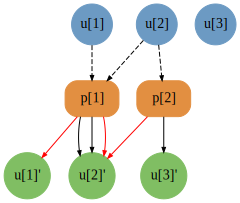

In [8]:
to_graphviz(bnsir)

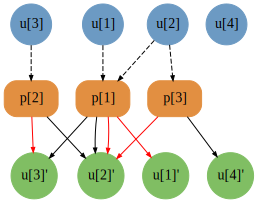

In [9]:
to_graphviz(bnseir)

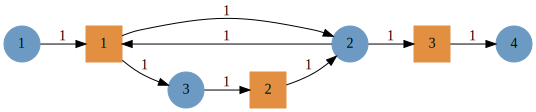

In [10]:
to_graphviz(bnrt)

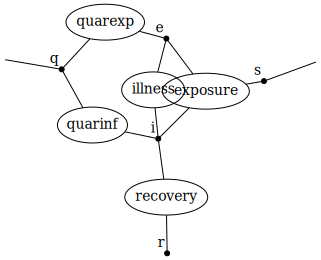

In [11]:
qm = @relation (s,q) begin
    exposure(s,i,e)
    illness(e,i)
    recovery(i,r)
    quarexp(e,q)
    quarinf(i,q)
end
display_uwd(qm)

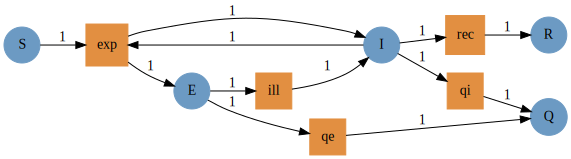

In [12]:
import AlgebraicPetri.Epidemiology: exposure_petri, spontaneous_petri
semantics = Dict(
    :infection => exposure_petri(:S, :I, :I, :inf),
    :exposure  => exposure_petri(:S, :I, :E, :exp),
    :illness   => spontaneous_petri(:E,:I,:ill),
    :recovery  => spontaneous_petri(:I,:R,:rec),
    :death     => spontaneous_petri(:I,:D,:death),
    :quarexp   => spontaneous_petri(:E, :Q, :qe),
    :quarinf   => spontaneous_petri(:I, :Q, :qi),
    :quarrec   => spontaneous_petri(:Q, :R, :qr)
)
pn_quar = oapply(qm, semantics)  |> apex
to_graphviz(pn_quar)

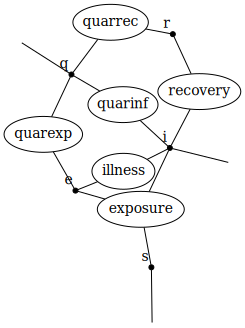

In [13]:
bnquar = LabelledBilayerNetwork()
migrate!(bnquar, pn_quar)
to_graphviz(bnquar)

qm = @relation (s,i,q) begin
    exposure(s,i,e)
    illness(e,i)
    recovery(i,r)
    quarexp(e,q)
    quarinf(i,q)
    quarrec(q,r)
end
display_uwd(qm)

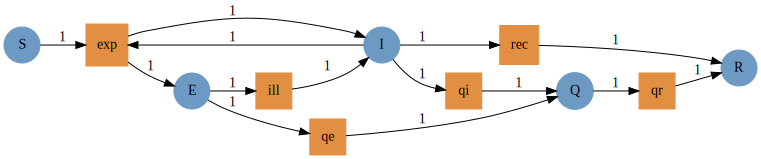

In [14]:
pn_quar = oapply(qm, semantics)  |> apex
to_graphviz(pn_quar)

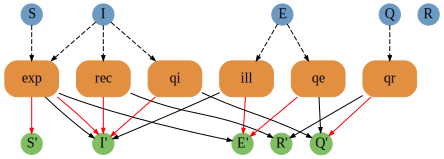

In [15]:
bnquar = LabelledBilayerNetwork()
migrate!(bnquar, pn_quar)
to_graphviz(bnquar)

In [16]:
quarrt = LabelledPetriNet()
migrate!(quarrt, bnquar) |> to_graphviz

bnquar

Qin,variable
1,S
2,I
3,E
4,R
5,Q
Qout,tanvar
1,S
2,I
3,E
4,R


In [17]:
import AlgebraicPetri.BilayerNetworks: evaluate!, evaluate

bnsir = LabelledBilayerNetwork()
migrate!(bnsir, psir)

evaluate(bnsir, [10.0, 1, 0.0], inf=0.1, rec=0.3)

evaluate(bnquar, [10.0, 1, 0, 0,0,0], exp=0.1, rec=0.3, qi=0.2, ill=0.7, qe=0.23, qr=0.3)

function euler(bn::AbstractLabelledBilayerNetwork, state, nsteps::Integer, stepsize::Real; params...)
    #preallocate storage so that each step is nonallocating
    #create a storage space for steps of euler's method store intermediate
    #states as named tuples so that you can integrate with julia Tables.jl data  analysis ecosystem
    du = zeros(length(state))
    ϕ = ones(nparts(bn, :Box))
    u = tuple(state...)
    results = Vector{NamedTuple{tuple(bn[:,:variable]...)}}()
    for i in 1:nsteps
        u = u .+ stepsize.*evaluate!(du, ϕ, bn, u; params...)
        push!(results, NamedTuple{tuple(bn[:,:variable]...)}(u))
    end
    return results
end

soln = euler(bnquar, (S=10.0, I=1, E=0, R=0, Q=0), 30, 0.15, exp=0.1, rec=0.03, qi=0.37, ill=0.7, qe=0.23, qr=0.03)
printsoln(bnquar, soln)

┌─────────┬──────────┬──────────┬────────────┬──────────┐
│       S │        I │        E │          R │        Q │
├─────────┼──────────┼──────────┼────────────┼──────────┤
│    9.85 │     0.94 │     0.15 │     0.0045 │   0.0555 │
│ 9.71111 │  0.89935 │  0.26796 │ 0.00897975 │ 0.112595 │
│ 9.58011 │ 0.873525 │ 0.361585 │  0.0135335 │ 0.171247 │
│ 9.45458 │  0.85908 │ 0.436671 │   0.018235 │ 0.231432 │
│ 9.33275 │ 0.853385 │ 0.497589 │  0.0231423 │ 0.293134 │
│ 9.21328 │ 0.854429 │ 0.547642 │  0.0283016 │ 0.356345 │
│  9.0952 │ 0.860666 │ 0.589327 │  0.0337501 │ 0.421056 │
│ 8.97778 │ 0.870905 │ 0.624535 │  0.0395178 │  0.48726 │
│  8.8605 │ 0.884227 │ 0.654694 │  0.0456296 │ 0.554949 │
│ 8.74298 │ 0.899916 │ 0.680885 │  0.0521059 │ 0.624113 │
│ 8.62496 │ 0.917414 │ 0.703921 │   0.058964 │ 0.694741 │
│ 8.50627 │ 0.936281 │ 0.724414 │  0.0662187 │ 0.766816 │
│ 8.38681 │ 0.956168 │ 0.742822 │  0.0738826 │ 0.840321 │
│ 8.26652 │ 0.976794 │ 0.759486 │  0.0819668 │ 0.915234 │
│  8.1454 │ 0.

In [18]:
import AlgebraicPetri.BilayerNetworks: compile
compile(bnquar, :du, :ϕ, :u, :p)

:(f!(du, ϕ, u, p, t) = begin
          #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:281 =#
          begin
              #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:287 =#
              du .= 0.0
              #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:288 =#
              ϕ .= 1.0
              ϕ[1] *= u[1]
              ϕ[1] *= u[2]
              ϕ[2] *= u[3]
              ϕ[3] *= u[2]
              ϕ[4] *= u[3]
              ϕ[5] *= u[2]
              ϕ[6] *= u[5]
              ϕ[1] *= p[:exp]
              ϕ[2] *= p[:ill]
              ϕ[3] *= p[:rec]
              ϕ[4] *= p[:qe]
              ϕ[5] *= p[:qi]
              ϕ[6] *= p[:qr]
              du[1] -= ϕ[1]
              du[2] -= ϕ[1]
              du[3] -= ϕ[2]
              du[2] -= ϕ[3]
              du[3] -= ϕ[4]
              du[2] -= ϕ[5]
              du[5] -= ϕ[6]
              du[3] += ϕ[1]
              du[2]

In [19]:
compile(bnquar, :du, :ϕ, :u, exp=0.1, rec=0.03, qi=0.37, ill=0.7, qe=0.23, qr=0.03)

:(f!(du, ϕ, u, t) = begin
          #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:282 =#
          begin
              #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:287 =#
              du .= 0.0
              #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:288 =#
              ϕ .= 1.0
              ϕ[1] *= u[1]
              ϕ[1] *= u[2]
              ϕ[2] *= u[3]
              ϕ[3] *= u[2]
              ϕ[4] *= u[3]
              ϕ[5] *= u[2]
              ϕ[6] *= u[5]
              ϕ[1] *= 0.1
              ϕ[2] *= 0.7
              ϕ[3] *= 0.03
              ϕ[4] *= 0.23
              ϕ[5] *= 0.37
              ϕ[6] *= 0.03
              du[1] -= ϕ[1]
              du[2] -= ϕ[1]
              du[3] -= ϕ[2]
              du[2] -= ϕ[3]
              du[3] -= ϕ[4]
              du[2] -= ϕ[5]
              du[5] -= ϕ[6]
              du[3] += ϕ[1]
              du[2] += ϕ[1]
           

In [20]:
function eulers(bn::AbstractLabelledBilayerNetwork, funcname::Symbol; params...)
    f = compile(bn, :du, :ϕ, :u; params...)
    varnames = tuple(bn[:,:variable]...)
    nϕ = nparts(bn, :Box)
    quote
    function $funcname(state, nsteps::Integer, stepsize::Real)
        $f
        #preallocate storage so that each step is nonallocating
        du = zeros(length(state))
        ϕ = ones($nϕ)
        u = tuple(state...)
        #create a storage space for steps of euler's method
        #store intermediate states as named tuples so that you can integrate
        #with julia Tables.jl data analysis ecosystem
        results = Vector{NamedTuple{$varnames}}()
        for i in 1:nsteps
            Δ = f!(du, ϕ, u, 0)
            u = u .+ stepsize.*Δ
            push!(results, NamedTuple{$varnames}(u))
        end
        return results
    end
    end
end

eulers(bnsir, :eulsir, inf=0.3, rec=0.2)

quote
    #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/docs/src/generated/other/bilayerconversion.ipynb:6 =#
    function eulsir(state, nsteps::Integer, stepsize::Real)
        #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/docs/src/generated/other/bilayerconversion.ipynb:6 =#
        #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/docs/src/generated/other/bilayerconversion.ipynb:7 =#
        f!(du, ϕ, u, t) = begin
                #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:282 =#
                begin
                    #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:287 =#
                    du .= 0.0
                    #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:288 =#
                    ϕ .= 1.0
                    ϕ[1] *= u[1]
                    ϕ[1] *= u[2]
                    ϕ[2] *= u[2]
                    ϕ[1] *= 0.3
                    

In [21]:
eulseirqexp = eulers(bnquar, :eulseirq, exp=0.1, rec=0.03, qi=0.37, ill=0.7, qe=0.23, qr=0.03)

quote
    #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/docs/src/generated/other/bilayerconversion.ipynb:6 =#
    function eulseirq(state, nsteps::Integer, stepsize::Real)
        #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/docs/src/generated/other/bilayerconversion.ipynb:6 =#
        #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/docs/src/generated/other/bilayerconversion.ipynb:7 =#
        f!(du, ϕ, u, t) = begin
                #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:282 =#
                begin
                    #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:287 =#
                    du .= 0.0
                    #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:288 =#
                    ϕ .= 1.0
                    ϕ[1] *= u[1]
                    ϕ[1] *= u[2]
                    ϕ[2] *= u[3]
                    ϕ[3] *= u[2]
                 

In [22]:
eulsirexp = eulers(bnsir, :eulsir, inf=0.3, rec=0.2)

quote
    #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/docs/src/generated/other/bilayerconversion.ipynb:6 =#
    function eulsir(state, nsteps::Integer, stepsize::Real)
        #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/docs/src/generated/other/bilayerconversion.ipynb:6 =#
        #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/docs/src/generated/other/bilayerconversion.ipynb:7 =#
        f!(du, ϕ, u, t) = begin
                #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:282 =#
                begin
                    #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:287 =#
                    du .= 0.0
                    #= /home/runner/work/AlgebraicPetri.jl/AlgebraicPetri.jl/src/BilayerNetworks.jl:288 =#
                    ϕ .= 1.0
                    ϕ[1] *= u[1]
                    ϕ[1] *= u[2]
                    ϕ[2] *= u[2]
                    ϕ[1] *= 0.3
                    

In [23]:
eval(eulsirexp)
soln_codegen = eulsir((S=10.0, I=1, R=0), 30, 0.15)
pretty_table(soln_codegen)

┌─────────────┬─────────┬──────────┐
│           S │       I │        R │
├─────────────┼─────────┼──────────┤
│        9.55 │    1.42 │     0.03 │
│     8.93976 │ 1.98764 │   0.0726 │
│     8.14015 │ 2.72762 │ 0.132229 │
│       7.141 │ 3.64494 │ 0.214058 │
│     5.96972 │ 4.70688 │ 0.323406 │
│     4.70527 │ 5.83011 │ 0.464613 │
│     3.47082 │ 6.88966 │ 0.639516 │
│     2.39475 │ 7.75905 │ 0.846206 │
│      1.5586 │ 8.36242 │  1.07898 │
│    0.972087 │ 8.69806 │  1.32985 │
│      0.5916 │ 8.81761 │  1.59079 │
│    0.356858 │ 8.78782 │  1.85532 │
│    0.215737 │ 8.66531 │  2.11895 │
│    0.131613 │ 8.48947 │  2.37891 │
│   0.0813334 │ 8.28507 │   2.6336 │
│     0.05101 │ 8.06684 │  2.88215 │
│    0.032493 │ 7.84335 │  3.12416 │
│   0.0210246 │ 7.61952 │  3.35946 │
│   0.0138157 │ 7.39814 │  3.58804 │
│  0.00921622 │  7.1808 │  3.80999 │
│  0.00623813 │ 6.96835 │  4.02541 │
│    0.004282 │ 6.76126 │  4.23446 │
│  0.00297918 │ 6.55972 │   4.4373 │
│  0.00209976 │ 6.36381 │  4.63409 │
│

In [24]:
eval(eulseirqexp)
soln_codegen = eulseirq((S=10.0, I=1, E=0, R=0, Q=0), 30, 0.15)
pretty_table(soln_codegen)

┌─────────┬──────────┬──────────┬────────────┬──────────┐
│       S │        I │        E │          R │        Q │
├─────────┼──────────┼──────────┼────────────┼──────────┤
│    9.85 │     0.94 │     0.15 │     0.0045 │   0.0555 │
│ 9.71111 │  0.89935 │  0.26796 │ 0.00897975 │ 0.112595 │
│ 9.58011 │ 0.873525 │ 0.361585 │  0.0135335 │ 0.171247 │
│ 9.45458 │  0.85908 │ 0.436671 │   0.018235 │ 0.231432 │
│ 9.33275 │ 0.853385 │ 0.497589 │  0.0231423 │ 0.293134 │
│ 9.21328 │ 0.854429 │ 0.547642 │  0.0283016 │ 0.356345 │
│  9.0952 │ 0.860666 │ 0.589327 │  0.0337501 │ 0.421056 │
│ 8.97778 │ 0.870905 │ 0.624535 │  0.0395178 │  0.48726 │
│  8.8605 │ 0.884227 │ 0.654694 │  0.0456296 │ 0.554949 │
│ 8.74298 │ 0.899916 │ 0.680885 │  0.0521059 │ 0.624113 │
│ 8.62496 │ 0.917414 │ 0.703921 │   0.058964 │ 0.694741 │
│ 8.50627 │ 0.936281 │ 0.724414 │  0.0662187 │ 0.766816 │
│ 8.38681 │ 0.956168 │ 0.742822 │  0.0738826 │ 0.840321 │
│ 8.26652 │ 0.976794 │ 0.759486 │  0.0819668 │ 0.915234 │
│  8.1454 │ 0.